<a href="https://colab.research.google.com/github/Gayathri-Chevuru/Fatigue-Detection/blob/main/p5asms4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dimension of train data:  (219307, 4)
Dimension of test data:  (54827, 4)
X_train.shape:  (54797, 30, 3)
y_train.shape:  (219277, 1)
X_test.shape:  (54797, 30, 3)
y_test.shape:  (219277, 1)
Epoch 1/10
5482/5482 [==============================] - 470s 84ms/step - loss: 1.0494e-04 - val_loss: 0.0260
Epoch 2/10
5482/5482 [==============================] - 480s 88ms/step - loss: 3.0939e-04 - val_loss: 0.0284
Epoch 3/10
5482/5482 [==============================] - 411s 75ms/step - loss: 4.3913e-04 - val_loss: 0.0304
Epoch 4/10
5482/5482 [==============================] - 410s 75ms/step - loss: 5.0174e-04 - val_loss: 0.0311
Epoch 5/10
5482/5482 [==============================] - 399s 73ms/step - loss: 5.2475e-04 - val_loss: 0.0309
Epoch 6/10
5482/5482 [==============================] - 399s 73ms/step - loss: 5.2195e-04 - val_loss: 0.0328
Epoch 7/10
5482/5482 [==============================] - 391s 71ms/step - loss: 6.2075e-04 - val_loss: 0.0306
Epoch 8/10
5482/5482 [=========================

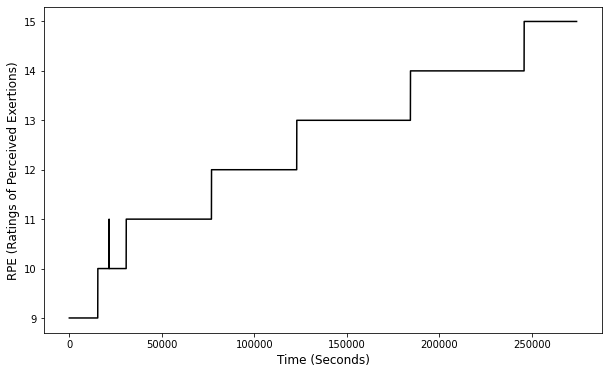

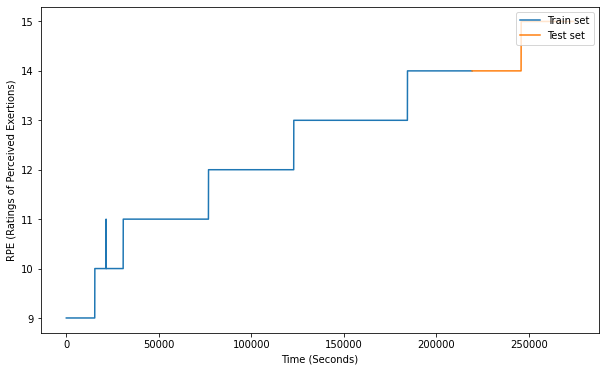

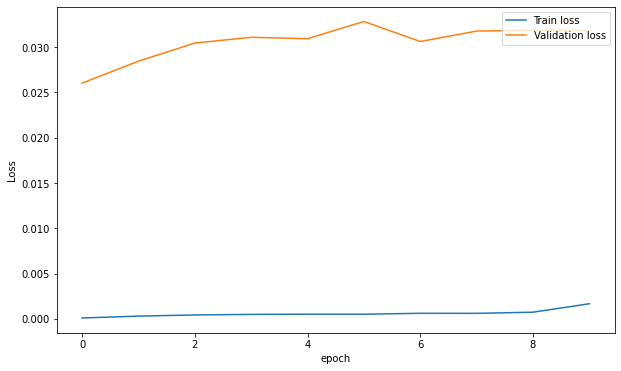

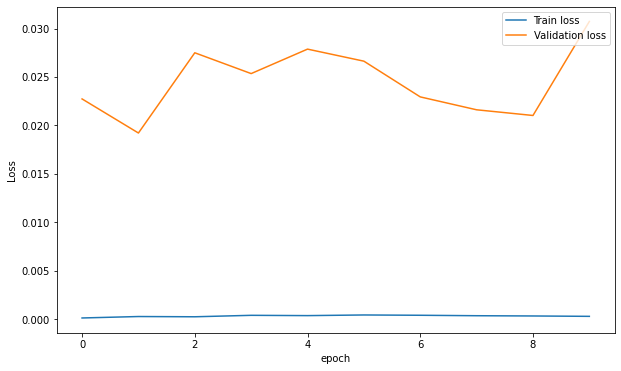

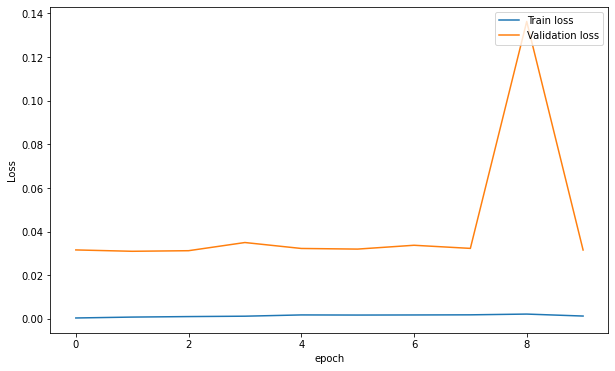

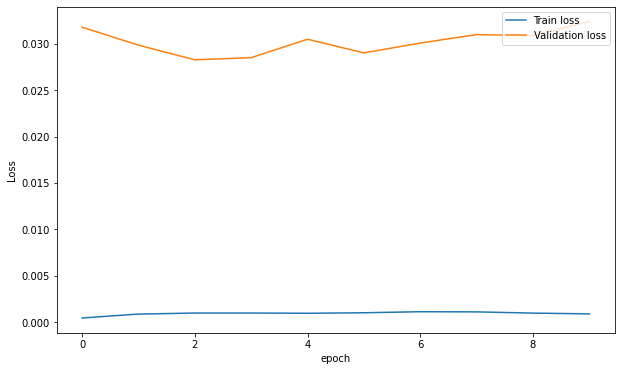

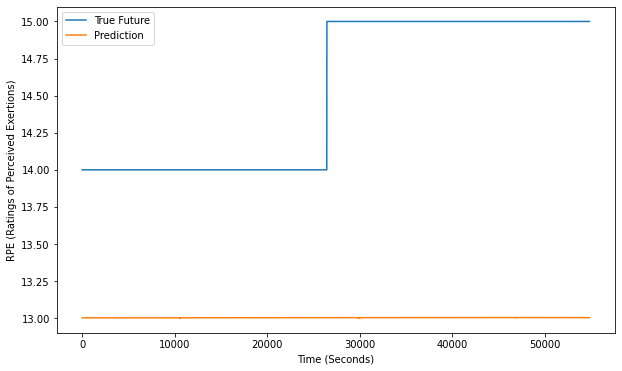

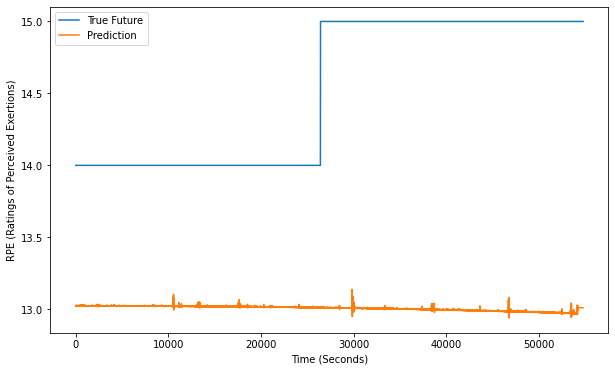

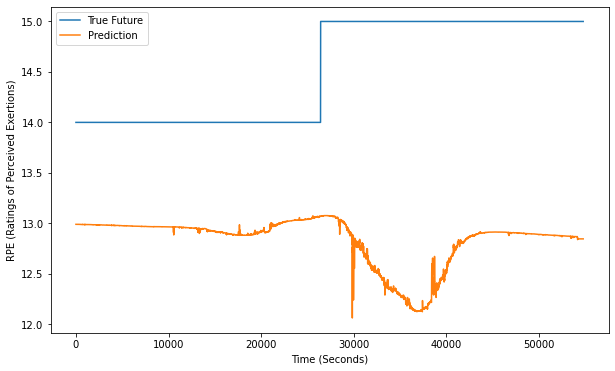

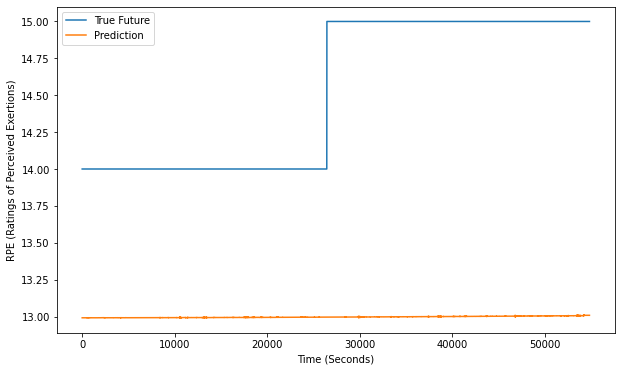

In [1]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np
import math


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Set random seed for reproducibility
tf.random.set_seed(1234) 

# Read file
file = 'p5asms4.csv'
raw_data = pd.read_csv(file)
df = raw_data.copy() 
df.head()
df.shape
df.describe()

# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})
timeseries(df.index, df['RPE'] ,'Time (Seconds)','RPE (Ratings of Perceived Exertions)')

# Check missing values
df.isnull().sum() 

# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)
replace_missing(df['time'])
replace_missing(df['sensor4_acc'])
replace_missing(df['sensor4_jerk'])
replace_missing(df['RPE']) 

# Split train data and test data
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]


# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.RPE)
plt.plot(test_dataset.RPE)
plt.xlabel('Time (Seconds)')
plt.ylabel('RPE (Ratings of Perceived Exertions)')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape) 


# Split train data to X and y
X_train = train_dataset.drop('RPE', axis = 1)
y_train = train_dataset.loc[:,['RPE']]
# Split test data to X and y
X_test = test_dataset.drop('RPE', axis = 1)
y_test = test_dataset.loc[:,['RPE']]  



# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)


# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 30
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create BiGRU model
def create_model_bigru(units):
    model = Sequential()
    model.add(Bidirectional(GRU(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(GRU(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model 

# BiLSTM and BiGRU
model_bigru = create_model_bigru(64)
model_bilstm = create_model_bilstm(64)

# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 10,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_bigru = fit_model(model_bigru)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_bilstm)
plot_loss (history_bigru)
plot_loss (history_lstm)
plot_loss (history_gru)

y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train) 

# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_bigru = prediction(model_bigru)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time (Seconds)')
    plt.ylabel('RPE (Ratings of Perceived Exertions)')
    
plot_future(prediction_bilstm, y_test)
plot_future(prediction_bigru, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)


# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_bigru, y_test, 'Bidirectional GRU')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')